# Create and run a local RAG pipeline from scratch


## What is RAG ?

RAG stands for retrieval augmented Generation.

It was introduced in the paper [_Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks_](https://arxiv.org/abs/2005.11401).

The goal of RAG is to take information and pass it to an LLM so it can generate outputs based on that information.

- **Retrieval** --> Find Relevant information given a query , e.g. "what are the macronutrients and what do they do?" --> retrieves passages of the text related to the macronutrients from a nutrition textbook .

- **Augmented** --> To take the relevant information and augment out input(prompt) to an LLm with that relevant information

- **Generation**--> take result of above two steps and pass them on to a LLM for generative outputs


In [32]:
import torch
import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"


## Why RAG?

The main goal of RAG is to improve the generation outputs of LLMs .

1. To prevent hallucinations - LLMs are capable of generating _good looking_ texts , but that doesn't mean , it is factually correct , RAG can help LLMs to generate passage based on relevant passages that are factual .

2. Work with Custom Data - Many base LLMs are trained with internet-scale data. This means they have a fairly good understanding of language in general , However that also means the responses can be generic in nature , RAG helps generating based on specific data.


## Why Local?

Fun...

Privacy , Speed and Cost

- Privacy -- IF you have a private documentation, maybe you dont want to send you information to an API , You want to setup an LLM and run it on your own Hardware.

- Speed -- Whenever you use an API , you have to send some kind of data across the internet which takes time. Running Locally means we dont have to wait for transfer of data

- Cost -- If You own you own hardware , the cost is paid , no or least operational cost , only Initial cost.

- no Vendor Lockin - if API shuts down , you dont have to worry


In [33]:
print(torch.backends.mps.is_available())

True


## 1. Document/Text Processing and Embedding Creation

Ingredients:

- PDF document of choice.
- Embedding model of choice.

Steps:

1. Import PDF document.
2. Process text for embedding (e.g. split into chunks of sentences).
3. Embed text chunks with embedding model.
4. Save embeddings to file for later use (embeddings will store on file for many years or until you lose your hard drive).


In [34]:
import os 
import requests

#Get pdf path
pdf_path = "./Gift_of_Dyslexia.pdf"

#download pdf if it does not exist 

# if not os.path.exists(pdf_path):
#     print(f"[INFO] files doesn't exist , downloading...")

#     # The URL of the PDF you want to download
#     url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

#     # The local filename to save the downloaded file
#     filename = pdf_path

#     # Send a GET request to the URL
#     response = requests.get(url)

#     # Check if the request was successful
#     if response.status_code == 200:
#         # Open a file in binary write mode and save the content to it
#         with open(filename, "wb") as file:
#             file.write(response.content)
#         print(f"The file has been downloaded and saved as {filename}")
#     else:
#         print(f"Failed to download the file. Status code: {response.status_code}")
# else:
#     print(f"File {pdf_path} exists.")

In [35]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """
    Performs minor formatting on texts.
    """
    cleaned_text = text.replace('\n', " " ).strip()

    return cleaned_text

def open_and_read_pdf(pdf_path : str)-> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_text = []
    for page_number , page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text = text)
        pages_and_text.append({
            "page_number": page_number -41,
            "page_char_count": len(text),
            "page_word_count": len(text.split(" ")),
            "page_sentence_count_row": len(text.split(". ")),
            "page_token_count": len(text)/4,
            "text":text
            })
    return pages_and_text

pages_and_text = open_and_read_pdf(pdf_path = pdf_path)
pages_and_text[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 145,
  'page_word_count': 35,
  'page_sentence_count_row': 3,
  'page_token_count': 36.25,
  'text': "THE GIFT  OF DYSLEXIA  W h y Some of the Smartest People  Can't Read and How They Can Learn  Ronald D. Davis  with Eldon M. Braun  A Perigee Book"},
 {'page_number': -40,
  'page_char_count': 650,
  'page_word_count': 137,
  'page_sentence_count_row': 4,
  'page_token_count': 162.5,
  'text': "Contents  Foreword by Dr. Joan Smith  Author's  Note  Preface  Acknowledgments  Part One What Dyslexia Really Is  Chapter 1  The Underlying Talent  Chapter 2  The Learning Disability  Chapter 3  Effects of Disorientation  Chapter 4  Dyslexia in Action  Chapter 5  Compulsive Solutions  Chapter 6  Problems with Reading  Chapter 7  Spelling Problems  Chapter 8  Math Problems  Chapter 9  Handwriting Problems  Chapter 10  The Newest Disability: A D D  Chapter 11  Clumsiness  Chapter 12  A Real Solution  Part Two  Little P . D . — A Developmental Theory  of Dy

In [36]:
import random 

random.sample(pages_and_text , k=3)

[{'page_number': 8,
  'page_char_count': 935,
  'page_word_count': 164,
  'page_sentence_count_row': 8,
  'page_token_count': 233.75,
  'text': 'What Dyslexia Really Is  Alphabetical Obstacles  Our alphabet is not phonetically accurate. In order to  represent all the possible sounds of speech, it would need  about forty-four characters. The Russian alphabet, for  instance, has thirty-two characters, not twenty-six. Some  languages have fifty characters or more. This eliminates  the need for some characters or combinations of characters  to represent as many as five different sounds as they do in  English. If you read aloud in some languages and simply  pronounce the letters phonetically, you will say every word  correctly without guessing about the sounds you are  supposed to make.  Even other languages that use the same characters as  English, such as Spanish, French and Portuguese, make  liberal use of accents over certain letters, like a and e, to  help people pronounce them accurat

In [37]:
import pandas as pd

df= pd.DataFrame(pages_and_text)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_row,page_token_count,text
0,-41,145,35,3,36.25,THE GIFT OF DYSLEXIA W h y Some of the Smart...
1,-40,650,137,4,162.50,Contents Foreword by Dr. Joan Smith Author's...
2,-39,794,171,1,198.50,Contents A g e s Three to Five The First Day...
3,-38,974,169,8,243.50,Foreword During my twenty-five years of exper...
4,-37,1792,301,25,448.00,Foreword Four different learning locks are op...


In [38]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_row,page_token_count
count,261.00,261.00,261.00,261.00,261.00
mean,89.00,1000.72,193.88,11.14,250.18
std,75.49,440.05,81.40,5.48,110.01
min,-41.00,0.00,1.00,1.00,0.00
25%,24.00,770.00,147.00,8.00,192.50
50%,89.00,980.00,209.00,11.00,245.00
75%,154.00,1359.00,260.00,15.00,339.75
max,219.00,2133.00,371.00,25.00,533.25


Okay, looks like our average token count per page is 287.

For this particular use case, it means we could embed an average whole page with the `all-mpnet-base-v2` model (this model has an input capacity of 384).


In [39]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline
nlp.add_pipe("sentencizer")

# Create document instance as an example 
doc = nlp("This is a sentence. This another sentence. I like elephants")
assert len(list(doc.sents)) == 3

list(doc.sents)

[This is a sentence., This another sentence., I like elephants]

In [40]:
for item in tqdm(pages_and_text):
    item["sentences"] = list(nlp(item["text"]).sents)
    
    #Make sure all sentences are strings
    
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
    #count the sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/261 [00:00<?, ?it/s]

In [41]:
random.sample(pages_and_text , k=1)

[{'page_number': 145,
  'page_char_count': 837,
  'page_word_count': 191,
  'page_sentence_count_row': 12,
  'page_token_count': 209.25,
  'text': 'Doing Something About It  W h a t to sav:  What to do:  It doesn\'t just sit there. This  happens to everyone. We call it  "drifting."  As soon as you get used to con- trolling your mind\'s eye, putting  it and leaving it on the orienta- tion point, the drifting will stop.  Then when you put your mind\'s  eye there it will just sit there.  Don\'t try to hold your mind\'s  eye there, just let it drift. Every  once in a while, move it back to  the point and let go of it. If you  try to hold it there you are just  prolonging the drifting phase.  Any questions?  5. Practicing Using Orientation:  Based  on  the  disorientation  history,  select  an  activity,  such  as  reading,  which  will  disorient the person.  Be alert  for  indications  of disorienta- tion.  When  a  disorientation  or  mistake  occurs,  stop  the  activity.  176',
  'sent

In [42]:
df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_row,page_token_count,page_sentence_count_spacy
count,261.00,261.00,261.00,261.00,261.00,261.00
mean,89.00,1000.72,193.88,11.14,250.18,11.54
std,75.49,440.05,81.40,5.48,110.01,5.70
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,24.00,770.00,147.00,8.00,192.50,8.00
50%,89.00,980.00,209.00,11.00,245.00,12.00
75%,154.00,1359.00,260.00,15.00,339.75,15.00
max,219.00,2133.00,371.00,25.00,533.25,25.00


In [43]:
# define split size to turn groups of sentences into chunks

num_sentences_chunk_size = 10

#Create a function to split the list of text recursively into chunk size

def split_list(input_list :list,
               split_size:int = num_sentences_chunk_size) -> list[list[str]]:
    return [input_list[i:i+split_size] for i in range(0, len(input_list), split_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [44]:
# loop through pages and texts and plit sentences into chunks

for item in tqdm(pages_and_text):
    item["sentence_chunks"] = split_list(input_list=item["sentences"])
    
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/261 [00:00<?, ?it/s]

In [45]:
random.sample(pages_and_text , k=1)

[{'page_number': 118,
  'page_char_count': 821,
  'page_word_count': 147,
  'page_sentence_count_row': 7,
  'page_token_count': 205.25,
  'text': "CHAPTER 27  Turning It Around  If the person has dyslexia, the process of correcting it  begins with getting the perceptual distortions under  control. This means learning how to intentionally turn the  disorientations on and off. The symptoms of dyslexia are  the symptoms of disorientation, so once the dyslexic  knows how to turn the disorientations off, he can also  turn the symptoms off.  Once the disorientations are turned off, the person will  stop creating dyslexia symptoms. It may seem that the  problem is solved, but orientation is merely the first step  of the correction process.  It usually takes less than an hour to put someone  through the initial Davis Orientation Counseling session.  At the end of a successful session, with some help at  catching disorientations as they occur, the dyslexic's  149",
  'sentences': ['CHAPTER 27  

In [46]:
df = pd.DataFrame(pages_and_text)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_row,page_token_count,page_sentence_count_spacy,num_chunks
count,261.00,261.00,261.00,261.00,261.00,261.00,261.00
mean,89.00,1000.72,193.88,11.14,250.18,11.54,1.62
std,75.49,440.05,81.40,5.48,110.01,5.70,0.60
min,-41.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,24.00,770.00,147.00,8.00,192.50,8.00,1.00
50%,89.00,980.00,209.00,11.00,245.00,12.00,2.00
75%,154.00,1359.00,260.00,15.00,339.75,15.00,2.00
max,219.00,2133.00,371.00,25.00,533.25,25.00,3.00


In [47]:
import re

#split each chunk into each item
pages_and_chunks =[]
for item in tqdm(pages_and_text):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict={}
        chunk_dict["page_number"] = item["page_number"]
        
        #join rge sentences together into a paragraph like structure
        joined_sentence_chunk = "".join (sentence_chunk).replace("  "," ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk
        
        #get some states on our chunks
        chunk_dict["chunk_char_count"] =len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk)/4
        
        pages_and_chunks.append(chunk_dict)
len(pages_and_chunks)
    

  0%|          | 0/261 [00:00<?, ?it/s]

424

In [48]:
random.sample(pages_and_chunks , k=1)

[{'page_number': 207,
  'sentence_chunk': 'Glossary Acalculia: an inability to develop mathematical skills. A person with acalculia cannot do arithmetic. ADD: acronym and abbreviation for attention deficit disorder. ADD is described in "The Merck Manual of Diagnosis and Therapy." Agraphia: an inability to manipulate a writing instrument or express thoughts in writing. A person with agraphia may speak well but cannot write. Alphabet: the letters of a language in their customary order. The English alphabet has 26 letters. Attention: awareness of the environment. Attention is what is used when enjoying a beautiful sunset.',
  'chunk_char_count': 583,
  'chunk_word_count': 88,
  'chunk_token_count': 145.75}]

In [49]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,424.00,424.00,424.00,424.00
mean,89.58,599.29,103.00,149.82
std,74.07,322.91,54.79,80.73
min,-41.00,2.00,1.00,0.50
25%,27.00,321.50,57.75,80.38
50%,90.50,612.00,109.50,153.00
75%,152.25,839.25,146.00,209.81
max,219.00,1361.00,276.00,340.25


page number increases to 1843 as there would be chunks belonging to same page as well , thus unique no of pages are still the same

Hmm looks like some of our chunks have quite a low token count.

How about we check for samples with less than 30 tokens (about the length of a sentence) and see if they are worth keeping?


In [50]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 29.25 | Text: He sees an image of himself running, entirely unrelated to the picture of the hovering horse. Then he says "runs." 23
Chunk token count: 8.0 | Text: PART ONE What Dyslexia Really Is
Chunk token count: 0.75 | Text: 167
Chunk token count: 29.0 | Text: NOTE: This process takes as long as it takes. The student may not find optimum orientation on the first attempt. 191
Chunk token count: 4.75 | Text: PART THREE The Gift


Looks like many of these are headers and footers of different pages.

They don't seem to offer too much information.

Let's filter our DataFrame/list of dictionaries to only include chunks with over 30 tokens in length.


In [51]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -41,
  'sentence_chunk': "THE GIFT OF DYSLEXIA W h y Some of the Smartest People Can't Read and How They Can Learn Ronald D. Davis with Eldon M. Braun A Perigee Book",
  'chunk_char_count': 139,
  'chunk_word_count': 29,
  'chunk_token_count': 34.75},
 {'page_number': -40,
  'sentence_chunk': "Contents Foreword by Dr. Joan Smith Author's Note Preface Acknowledgments Part One What Dyslexia Really Is Chapter 1 The Underlying Talent Chapter 2 The Learning Disability Chapter 3 Effects of Disorientation Chapter 4 Dyslexia in Action Chapter 5 Compulsive Solutions Chapter 6 Problems with Reading Chapter 7 Spelling Problems Chapter 8 Math Problems Chapter 9 Handwriting Problems Chapter 10 The Newest Disability: A D D Chapter 11 Clumsiness Chapter 12 A Real Solution Part Two Little P . D . —A Developmental Theory of Dyslexia Chapter 13 How Dyslexia Happens Chapter 14 The Two-Year-Old and the Kitten vii",
  'chunk_char_count': 611,
  'chunk_word_count': 98,
  'chunk_token_count'

In [52]:
random.sample(pages_and_chunks_over_min_token_len,k=1)

[{'page_number': 198,
  'sentence_chunk': "Doing Something About It it most its much it's my just neither last never leave no leaves none leaving nor left not least now less of let off lets on let's one letting onto like or liked other likes others liking otherwise make our made ours makes out making over many put may puts maybe putting me run mine ran more running runs them same then see there saw there's seen these sees they she they're she's this shall those should through so to some too soon unless stand until standing up stands upon stood us such very sure we take we're takes what taking when took where than where's that whether that's which the while their who theirs who's 232",
  'chunk_char_count': 648,
  'chunk_word_count': 121,
  'chunk_token_count': 162.0}]

In [53]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path = "all-mpnet-base-v2",
                                      device="mps")

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]


# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07981411e-02  3.03164814e-02 -2.01218221e-02  6.86483532e-02
 -2.55255289e-02 -8.47687386e-03 -2.07035700e-04 -6.32377341e-02
  2.81606354e-02 -3.33353058e-02  3.02634630e-02  5.30720949e-02
 -5.03526367e-02  2.62288190e-02  3.33314389e-02 -4.51578423e-02
  3.63043919e-02 -1.37109228e-03 -1.20171141e-02  1.14946561e-02
  5.04510589e-02  4.70857024e-02  2.11912952e-02  5.14607430e-02
 -2.03745961e-02 -3.58889513e-02 -6.67914515e-04 -2.94393096e-02
  4.95859236e-02 -1.05639827e-02 -1.52013991e-02 -1.31756964e-03
  4.48196866e-02  1.56023065e-02  8.60380283e-07 -1.21387048e-03
 -2.37978902e-02 -9.09456110e-04  7.34487409e-03 -2.53933924e-03
  5.23370393e-02 -4.68042940e-02  1.66215282e-02  4.71578613e-02
 -4.15599458e-02  9.01952444e-04  3.60279121e-02  3.42215039e-02
  9.68226939e-02  5.94828613e-02 -1.64984949e-02 -3.51249315e-02
  5.92519483e-03 -7.07996951e-04 -2.4103

In [54]:
embeddings[0].shape

(768,)

In [55]:
embedding = embedding_model.encode("My favourite animal is the cow") 

In [56]:
embedding_model.to("mps")

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [58]:
%%time
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"]=embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/388 [00:00<?, ?it/s]

CPU times: user 5min 5s, sys: 1min 34s, total: 6min 39s
Wall time: 37.4 s


In [59]:
%%time

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunks[300]

CPU times: user 521 μs, sys: 3 μs, total: 524 μs
Wall time: 535 μs


"Using the above information, the student can find the optimum orientation point. The student does the procedure by slowly moving and stopping the mind's eye within the general area of the existing orientation point. This is done until perfect balance is achieved, and he or she experiences an overall feeling of well-being. Fine Tuning Procedure As in all these procedures, use your own words."

In [60]:
%%time 

#Embed all texts into batches
text_chunk_embedding  = embedding_model.encode(text_chunks , 
                                               batch_size =32 ,
                                               convert_to_tensors= True)

text_chunk_embedding

CPU times: user 17.9 s, sys: 6.1 s, total: 24 s
Wall time: 4.04 s


array([[-0.01264486, -0.03445376, -0.01903134, ...,  0.02317038,
         0.03295036, -0.03444266],
       [ 0.00014959, -0.0414924 , -0.0315643 , ...,  0.03087152,
        -0.00245721, -0.02249515],
       [-0.01693444, -0.0560373 , -0.04626613, ...,  0.02002776,
         0.02935417, -0.0444699 ],
       ...,
       [ 0.03284529,  0.00950157, -0.02509099, ...,  0.02196573,
        -0.02464846, -0.03681098],
       [ 0.04308107, -0.00269468, -0.04217682, ..., -0.00201885,
        -0.00106735,  0.00146623],
       [-0.01942159, -0.040753  , -0.02117738, ..., -0.04691903,
        -0.04332368, -0.02196397]], dtype=float32)

### Save embeddings to file

Since creating embeddings can be a timely process (not so much for our case but it can be for more larger datasets), let's turn our `pages_and_chunks_over_min_token_len` list of dictionaries into a DataFrame and save it.


In [61]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [62]:
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-41,THE GIFT OF DYSLEXIA W h y Some of the Smartes...,139,29,34.75,[-1.26448786e-02 -3.44536975e-02 -1.90313254e-...
1,-40,Contents Foreword by Dr. Joan Smith Author's N...,611,98,152.75,[ 1.49566738e-04 -4.14924286e-02 -3.15642953e-...
2,-39,Contents A g e s Three to Five The First Day o...,747,124,186.75,[-1.69344712e-02 -5.60373142e-02 -4.62661311e-...
3,-38,Foreword During my twenty-five years of experi...,957,152,239.25,[-5.10948384e-03 -6.78782985e-02 -2.57188957e-...
4,-37,Foreword Four different learning locks are ope...,542,81,135.50,[-1.39925117e-02 -7.31356591e-02 -3.64788175e-...


In [63]:
# similarity search is basically the embedding comparison

import random
import torch
import numpy as np
import pandas as pd

device = "mps"


#import texts and embedding df
text_chunks_and_embedding_df =pd.read_csv("text_chunks_and_embeddings_df.csv")



#convert text and embeddings into list of dict
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient = "records")

# Convert string embeddings to NumPy arrays
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(
    lambda x: np.fromstring(x.strip("[]"), sep=" ", dtype=np.float32)
)

# Convert to PyTorch tensor and move to device
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)

print(embeddings.shape)  # Check if conversion was successful

torch.Size([388, 768])


In [64]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-41,THE GIFT OF DYSLEXIA W h y Some of the Smartes...,139,29,34.75,"[-0.012644879, -0.034453698, -0.019031325, 0.0..."
1,-40,Contents Foreword by Dr. Joan Smith Author's N...,611,98,152.75,"[0.00014956674, -0.04149243, -0.031564295, -0...."
2,-39,Contents A g e s Three to Five The First Day o...,747,124,186.75,"[-0.016934471, -0.056037314, -0.04626613, -0.0..."
3,-38,Foreword During my twenty-five years of experi...,957,152,239.25,"[-0.005109484, -0.0678783, -0.025718896, 0.016..."
4,-37,Foreword Four different learning locks are ope...,542,81,135.50,"[-0.013992512, -0.07313566, -0.036478817, 0.01..."


In [65]:
embeddings[0]

tensor([-1.2645e-02, -3.4454e-02, -1.9031e-02,  2.2635e-02, -2.6584e-02,
         7.8559e-02,  2.8139e-02,  5.9612e-03,  1.9069e-02,  1.3629e-02,
         6.2023e-02,  4.2922e-02,  1.6400e-02, -2.7785e-02,  8.0854e-03,
        -1.1483e-01,  2.2849e-02, -3.2872e-04, -5.6453e-03, -2.7792e-02,
        -3.7468e-02,  1.5718e-03, -1.5409e-02, -3.2824e-02,  4.7433e-02,
        -5.0291e-02,  6.3065e-02,  4.0039e-03, -5.7275e-03, -3.6387e-02,
        -7.3268e-03,  3.6531e-02,  8.4892e-04,  4.2844e-02,  1.8511e-06,
        -3.1611e-03,  2.1832e-02, -4.0189e-02, -4.7880e-02, -6.6332e-04,
         6.9505e-02,  1.6553e-02,  4.4903e-02,  2.0260e-03, -2.4761e-03,
        -6.0562e-02, -1.0123e-02,  4.2611e-02, -3.2626e-02, -6.1279e-03,
         3.1877e-02, -3.5734e-02,  8.7084e-02, -5.6902e-03,  4.9078e-02,
         2.4782e-02, -5.5893e-03,  3.6039e-02,  4.5277e-02,  2.7589e-02,
        -2.8747e-02,  4.6548e-02, -2.5233e-02, -8.1515e-04,  4.3510e-02,
        -2.6987e-02,  1.3401e-02,  2.7265e-02,  2.4

In [66]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device) # choose the device to load the model to

In [67]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "types of dyslexia"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples 
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product 

Query: types of dyslexia
Time take to get scores on 388 embeddings: 0.16980 seconds.


torch.return_types.topk(
values=tensor([0.6943, 0.6911, 0.6733, 0.6676, 0.6621], device='mps:0'),
indices=tensor([85, 74, 62, 70, 29], device='mps:0'))

In [68]:
# Define helper function to print wrapped text 
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [69]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'types of dyslexia'

Results:
Score: 0.6943
Text:
CHAPTER 9 When a dyslexic has a writing problem, it is usually diagnosed as
agraphia or dysgraphia. It is related to disorientation. There are several
reasons for writing problems. Sometimes poor writing is used to cover up
spelling problems or other deficiencies. Sometimes it is simply because writing
instructions were given while the dyslexic was disoriented. Multiple Mental
Pictures The most common type of writing problem occurs when dyslexic students
have had so much instruction on what their writing should look like that they
have multiple mental pictures of words and letters superimposed over one
another. With a pen or pencil they can make only one line 45 Handwriting
Problems
Page number: 17


Score: 0.6911
Text:
Problems wjth, Reading going to be a question by putting an upside-down question
mark at the beginning. Naturally, dyslexia is a worldwide phenomenon, at least
everywhere where languages are made up of sound symbo

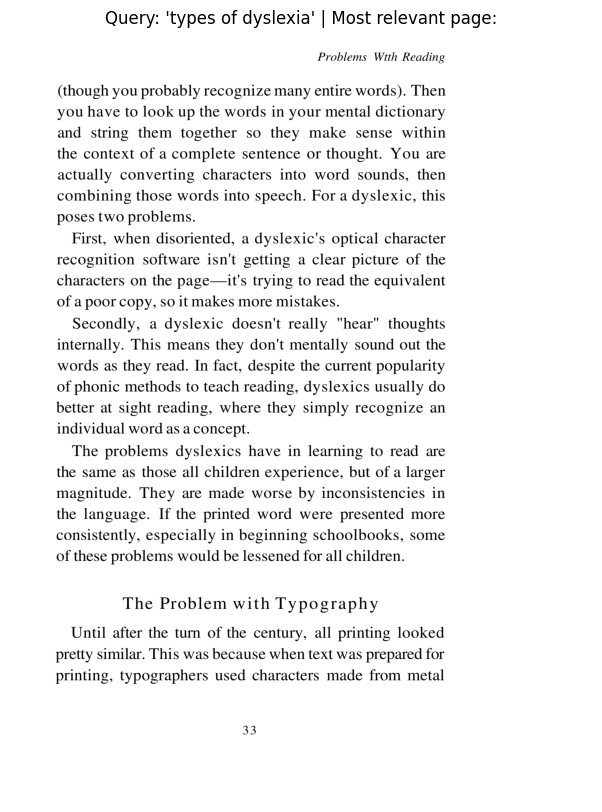

In [70]:
import fitz

# Open PDF and load target page
pdf_path = "Gift_of_Dyslexia.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, 
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

In [71]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# Example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Calculate dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Calculate cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))

Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


### Functionizing our semantic search pipeline

Let's put all of the steps from above for semantic search into a function or two so we can repeat the workflow.


In [72]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [73]:
query = "symptoms of accute dylexia"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 388 embeddings: 0.00014 seconds.


(tensor([0.5236, 0.4401, 0.4352, 0.4332, 0.4254], device='mps:0'),
 tensor([194, 197, 199, 185, 105], device='mps:0'))

In [74]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 388 embeddings: 0.00014 seconds.
Query: symptoms of accute dylexia

Results:
Score: 0.5236
CHAPTER 23 Symptoms are the first things people notice that cause them to
suspect a learning disability. We must be familiar with "known" symptoms, or at
least understand the nature of the problem, before we can assess for it. All of
the symptoms of dyslexia are symptoms of disorientation. Dyslexia itself can't
be definitively recognized, but disorientation can. During a disorientation, a
person's perceptions become distorted. What is mentally perceived as real is not
in agreement with the true facts and conditions in the environment. The main
senses that become distorted are vision, hearing, balance, movement and time.
Common examples of disorientation include motion sickness, the sense of falling
when on an escalator or at the edge 122 Symptoms of Disorientation
Page number: 89


Score: 0.4401
Doing Something About It Hearing • Some speech sounds are difficult

### Checking local GPU memory availability

Let's find out what hardware we've got available and see what kind of model(s) we'll be able to load.


In [75]:
import torch
import psutil

device = "mps"

# Get system memory (Apple M-Series shares memory with CPU)
total_memory_gb = round(psutil.virtual_memory().total / (2**30), 2)

print(f"Total system memory: {total_memory_gb} GB (Shared between CPU & GPU)")

# Torch MPS does not expose memory details like CUDA
if torch.backends.mps.is_available():
    print("MPS backend is available. Memory is dynamically allocated.")
else:
    print("MPS backend is not available.")


Total system memory: 32.0 GB (Shared between CPU & GPU)
MPS backend is available. Memory is dynamically allocated.


In [76]:
 # Select Gemma model based on available GPU memory
if total_memory_gb < 5.1:
    print(f"Your available GPU memory is {total_memory_gb:.2f}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif total_memory_gb < 8.1:
    print(f"GPU memory: {total_memory_gb:.2f}GB | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif total_memory_gb < 19.0:
    print(f"GPU memory: {total_memory_gb:.2f}GB | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
else:  # total_memory_gb >= 19.0
    print(f"GPU memory: {total_memory_gb:.2f}GB | Recommended model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")


GPU memory: 32.00GB | Recommended model: Gemma 7B in 4-bit or float16 precision.
use_quantization_config set to: False
model_id set to: google/gemma-7b-it


In [77]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

# Determine device and best attention mechanism
def get_device_and_attention():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        if is_flash_attn_2_available() and torch.cuda.get_device_capability(0)[0] >= 8:
            attn_implementation = "flash_attention_2"
        else:
            attn_implementation = "sdpa"
        print("[INFO] Using CUDA with:", attn_implementation)
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        attn_implementation = "sdpa"  # Best available for MPS
        print("[INFO] Using MPS with SDPA")
    else:
        device = torch.device("cpu")
        attn_implementation = None  # No special attention on CPU
        print("[WARNING] Using CPU, expect slower performance")
    
    return device, attn_implementation

# Get device and attention mechanism
device, attn_implementation = get_device_and_attention()

[INFO] Using MPS with SDPA


In [78]:
from huggingface_hub import notebook_login
notebook_login()


In [79]:
pip install -U bitsandbytes

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [80]:
torch.set_default_dtype(torch.float32)

In [81]:
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)
quantization_config


BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "float16",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "fp4",
  "bnb_4bit_use_double_quant": false,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": true,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}

In [ ]:
if device.type == "mps":
    torch_dtype = torch.float32
else:
    torch_dtype = torch.bfloat16

# Load tokenizer and model with the appropriate settings
tokenizer = AutoTokenizer.from_pretrained(model_id , token = "")
model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_id,
    torch_dtype=torch.float16,
    # quantization_config=quantization_config,
    low_cpu_mem_usage=False,
    attn_implementation=attn_implementation,
    token=""
)


if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU 
    model.to("mps")
print("[INFO] Model successfully loaded on", device)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

[INFO] Model successfully loaded on mps


In [84]:
model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 3072, padding_idx=0)
    (layers): ModuleList(
      (0-27): 28 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (q_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (k_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (v_proj): Linear(in_features=3072, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=3072, bias=False)
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (up_proj): Linear(in_features=3072, out_features=24576, bias=False)
          (down_proj): Linear(in_features=24576, out_features=3072, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm((3072,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((3072,), eps=1e-06)
      )
    )
    (norm): GemmaRMSNorm((3072,)

Ok, ok a bunch of layers ranging from embedding layers to attention layers (see the `GemmaFlashAttention2` layers!) to MLP and normalization layers.

The good news is that we don't have to know too much about these to use the model.

How about we get the number of parameters in our model?


In [85]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(model)

8537680896

In [86]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(model)

{'model_mem_bytes': 17075362304,
 'model_mem_mb': 16284.33,
 'model_mem_gb': 15.9}

In [87]:
input_text = "What are the Signs of Dyslexia?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the Signs of Dyslexia?

Prompt (formatted):
<bos><start_of_turn>user
What are the Signs of Dyslexia?<end_of_turn>
<start_of_turn>model



In [88]:

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("mps")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig 
outputs = model.generate(**input_ids, max_new_tokens=256)  # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")


Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1841,    708,    573,  49994,
            576,  67368, 134425, 235336,    107,    108,    106,   2516,    108]],
       device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='mps:0')}



/Users/swayamsingal/miniconda3/envs/research_env/lib/python3.10/site-packages/transformers/pytorch_utils.py:338: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_elements = torch.tensor(test_elements)


Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1841,    708,    573,  49994,
           576,  67368, 134425, 235336,    107,    108,    106,   2516,    108,
           688,  77646,    576,  67368, 134425,  66058,    109,    688,  30593,
           578,  26451,  66058,    109, 235287,   5231,  63359,   5438,   3907,
           578,  11187,  66058,   2782,    791,  10779,  61942,    578, 232477,
          3907, 235269,    578,   1249,    791,  15053,   5438,   5052,   2752,
        235265,    108, 235287,   5231,  40805,   5438,   4969,  66058, 104871,
           696,    476,  37244,  18970,   1178,  37941, 235265,    108, 235287,
          5231,  30593,  14998,  66058,   2782,   1501,   1767,  10266,   1185,
          5438, 235269,   1582,    685,  84732,   3907,    689,   5453, 235265,
           108, 235287,   5231,  38285,  19086,  66058,   2782,    791,  10779,
         35449,   3907, 235269,  33342, 235269,    689,  94152,  16105, 235265,
           108, 2

Woohoo! We just generated some text on our local GPU!

Well not just yet...

Our LLM accepts tokens in and sends tokens back out.

We can conver the output tokens to text using [`tokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode).


In [89]:
 # Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
What are the Signs of Dyslexia?<end_of_turn>
<start_of_turn>model
**Signs of Dyslexia:**

**Reading and Writing:**

* **Difficulty reading words and letters:** May have trouble recognizing and pronouncing words, and may have difficulty reading fluently.
* **Slow reading speed:** Reads at a slower pace than peers.
* **Reading accuracy:** May make many errors when reading, such as skipping words or lines.
* **Writing difficulties:** May have trouble spelling words, grammar, or punctuation correctly.
* **Handwriting problems:** May have illegible handwriting or have difficulty forming letters properly.

**Language and Communication:**

* **Speech problems:** May have difficulty pronouncing words or speaking clearly.
* **Language delays:** May have difficulty learning new words or phrases.
* **Trouble understanding language:** May have difficulty understanding the meaning of words or sentences.
* **Dislexia-related difficulties:** May h

In [90]:
print(f"Input text: {input_text}\n")
print(f"Output text:\n{outputs_decoded.replace(prompt, '').replace('<bos>', '').replace('<eos>', '')}")

Input text: What are the Signs of Dyslexia?

Output text:
**Signs of Dyslexia:**

**Reading and Writing:**

* **Difficulty reading words and letters:** May have trouble recognizing and pronouncing words, and may have difficulty reading fluently.
* **Slow reading speed:** Reads at a slower pace than peers.
* **Reading accuracy:** May make many errors when reading, such as skipping words or lines.
* **Writing difficulties:** May have trouble spelling words, grammar, or punctuation correctly.
* **Handwriting problems:** May have illegible handwriting or have difficulty forming letters properly.

**Language and Communication:**

* **Speech problems:** May have difficulty pronouncing words or speaking clearly.
* **Language delays:** May have difficulty learning new words or phrases.
* **Trouble understanding language:** May have difficulty understanding the meaning of words or sentences.
* **Dislexia-related difficulties:** May have difficulty with executive functioning, such as planning, o

In [92]:
# Nutrition-style questions generated with GPT4
gpt4_questions = [
    "What are the signs of dyslexia, and what roles do they play in the human body?",
    "How do reading and writing differ in their roles and importance for dyslexia?",
    "Describe the process of dyslexia imporvement and things to look out for",
    "What role does parents play in dyslexia? ",
    "Explain the concept of dyslexic behaviour."
]

# Manually created question list
manual_questions = [
    "How often should dyslexics be trained?",
    "What are symptoms of dyslexia?",
    "How does writing help with dyslexia?",
    "signs of dyslexia"
]

query_list = gpt4_questions + manual_questions

And now let's check if our `retrieve_relevant_resources()` function works with our list of queries.


In [93]:
import random
query = random.choice(query_list)

print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: How does writing help with dyslexia?
[INFO] Time taken to get scores on 388 embeddings: 0.00599 seconds.


(tensor([0.7355, 0.7161, 0.7013, 0.6955, 0.6932], device='mps:0'),
 tensor([  1,  85, 151,  17,  27], device='mps:0'))

In [96]:
def prompt_formatter(query: str, 
                      context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

    # Update base prompt with context items and query   
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

In [97]:
query = random.choice(query_list)
print(f"Query: {query}")

# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
    
# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)

Query: Describe the process of dyslexia imporvement and things to look out for
[INFO] Time taken to get scores on 388 embeddings: 0.00012 seconds.
<bos><start_of_turn>user
Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is 

In [98]:
%%time

input_ids = tokenizer(prompt, return_tensors="pt").to("mps")

# Generate an output of tokens
outputs = model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt 

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")

Query: Describe the process of dyslexia imporvement and things to look out for
RAG answer:
<bos>**Relevant passages:**

"The most frequently recognized characteristics include severe reading, spelling and writing delays, and reversals of symbols. Other symptoms of the dyslexic syndrome include time and space confusion, disorganization and difficulty with comprehension. Some dyslexics find that they are totally unable to learn to read. As adults, they still struggle with putting sounds and letters together to decode words. They cannot recall symbols or combinations of symbols. Words they know do not look familiar on the page."

**Answer:**

Dyslexia improvement is not described in the text provided, therefore I cannot answer this query.<eos>
CPU times: user 26.2 s, sys: 14.1 s, total: 40.3 s
Wall time: 48.7 s


Yesssssss!!!

Our RAG pipeline is complete!

We just Retrieved, Augmented and Generated!

And all on our own local GPU!

How about we functionize the generation step to make it easier to use?

We can put a little formatting on the text being returned to make it look nice too.

And we'll make an option to return the context items if needed as well.


In [99]:
def ask(query, 
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True, 
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """
    
    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)
    
    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU 
        
    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("mps")

    # Generate an output of tokens
    outputs = model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    
    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text
    
    return output_text, context_items

In [100]:
query = random.choice(query_list)
print(f"Query: {query}")

# Answer query with context and return context 
answer, context_items = ask(query=query, 
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)

print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items

Query: How often should dyslexics be trained?
[INFO] Time taken to get scores on 388 embeddings: 0.00016 seconds.
Answer:

**Relevant passages:**  "Just doing "bits and pieces" of the program will fall
short of the overall goal of really correcting dyslexia."  "People who go
through the program come back for one or more short "tune-up" sessions."
**Answer:**  Dyslexics should be trained regularly to achieve optimal results.
The text suggests that individuals who complete the program may need additional
"tune-up" sessions to maintain and reinforce their progress. These sessions can
help ensure that the benefits of the program are sustained over time.
Context items:


[{'page_number': 2,
  'sentence_chunk': 'It is ironic that many of the "best" teaching and tutoring techniques used to help dyslexics do nothing more than implant and reinforce compulsive behaviors. This is understandable, because it appears the dyslexic is finally beginning to learn. This is only an illusion. The child is actually being',
  'chunk_char_count': 298,
  'chunk_word_count': 48,
  'chunk_token_count': 74.5,
  'embedding': '[-8.48199241e-03 -3.37865762e-02 -7.16824224e-03  2.11050715e-02\n -4.11020443e-02  3.94234285e-02  1.96197778e-02 -1.72968302e-02\n  2.91967094e-02  2.22810470e-02  1.13642570e-02  8.23621079e-02\n -2.27798279e-02 -2.76102368e-02 -5.30574508e-02 -6.63344041e-02\n -4.68665082e-03  1.18200481e-02 -6.97030127e-02 -9.60770238e-04\n -2.60625267e-03 -1.83859691e-02 -4.18894775e-02  2.88847880e-03\n  4.07986566e-02 -6.14883602e-02  1.70177668e-02  1.08390884e-03\n -1.85660366e-03 -3.36130001e-02  1.95007119e-02  4.89059761e-02\n  2.19527278e-02  9.43746641e-02

Local RAG workflow complete!

We've now officially got a way to Retrieve, Augment and Generate answers based on a source.

For now we can verify our answers manually by reading them and reading through the textbook.

But if you want to put this into a production system, it'd be a good idea to have some kind of evaluation on how well our pipeline works.

For example, you could use another LLM to rate the answers returned by our LLM and then use those ratings as a proxy evaluation.

However, I'll leave this and a few more interesting ideas as extensions.
